In [6]:
import tensorflow as tf
print(tf.test.gpu_device_name())

/device:GPU:0


# CS 512 F24: Assignment 4
Due by 11/2/2024

**Name:** Tamilarasee Sethuraj

**Student ID:** A20553416




# 2. Object Detection

1. Dataset: Use the oxford _iiit_pet dataset from Keras or PyTorch.
- For object detection, you will need to find bounding boxes that correspond to the pet objects in the segmentation masks. To create a bounding box for each pet, you can:
  - Identify the non-background pixels in the segmentation mask.
  - Compute the minimum and maximum coordinates (xmin, xmax, ymin, ymax) that enclose all the pet pixels. This will give you a bounding box for each image around the pet object.
  - Example of how to calculate bounding boxes from segmentation masks:provided



In [7]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Load oxford Pet Dataset
dataset, info = tfds.load('oxford_iiit_pet', with_info= True, as_supervised = False)

#Split into training and testing datasets
train_dataset = dataset['train']
test_dataset = dataset['test']



Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.QZD9BD_3.2.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.QZD9BD_3.2.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [8]:
for instance in train_dataset.take(1):
    label = instance['species']
    mask = tf.image.convert_image_dtype(instance['segmentation_mask'], tf.float32)
    image = tf.image.convert_image_dtype(instance['image'], tf.float32)
    mask = tf.cast(mask, tf.int32)

    print(f"\nImage shape: {image.shape}")
    print(f"mask shape: {mask.shape}")

    print("label for cat (0) or dog (1): ", label)


Image shape: (500, 500, 3)
mask shape: (500, 500, 1)
label for cat (0) or dog (1):  tf.Tensor(0, shape=(), dtype=int64)



Image shape: (128, 128, 3)
mask shape: (128, 128, 1)


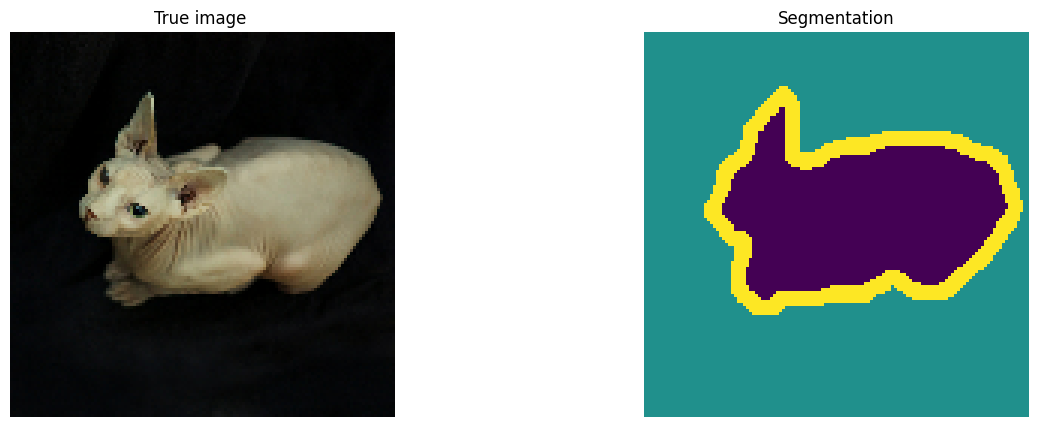


Image shape: (128, 128, 3)
mask shape: (128, 128, 1)


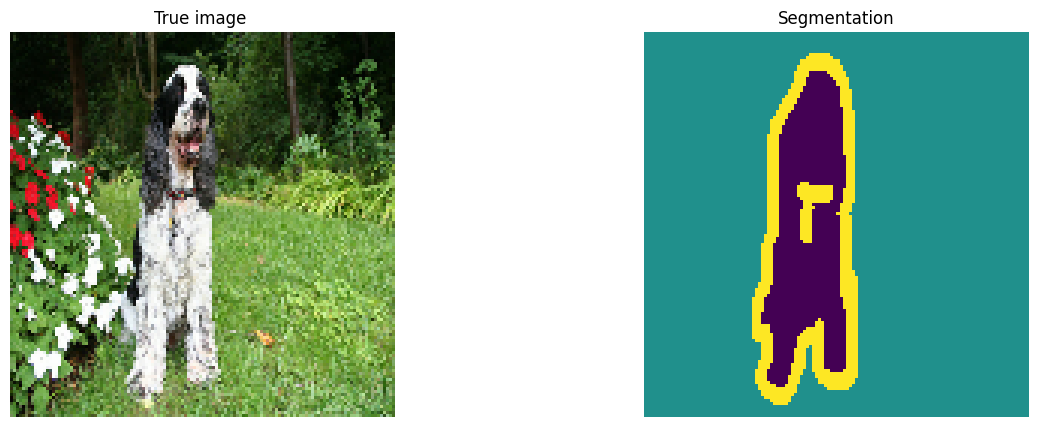

In [9]:
for instance in train_dataset.take(2):
    image = tf.image.resize(instance['image'], (128, 128))
    image = tf.image.convert_image_dtype(image, tf.float32)

    mask = tf.image.resize(instance['segmentation_mask'], (128, 128), method = 'nearest')
    mask = tf.cast(mask, tf.int32)

    print(f"\nImage shape: {image.shape}")
    print(f"mask shape: {mask.shape}")

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image.numpy()/255)
    plt.title("True image ")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask.numpy())
    plt.title("Segmentation")
    plt.axis('off')

    plt.show()

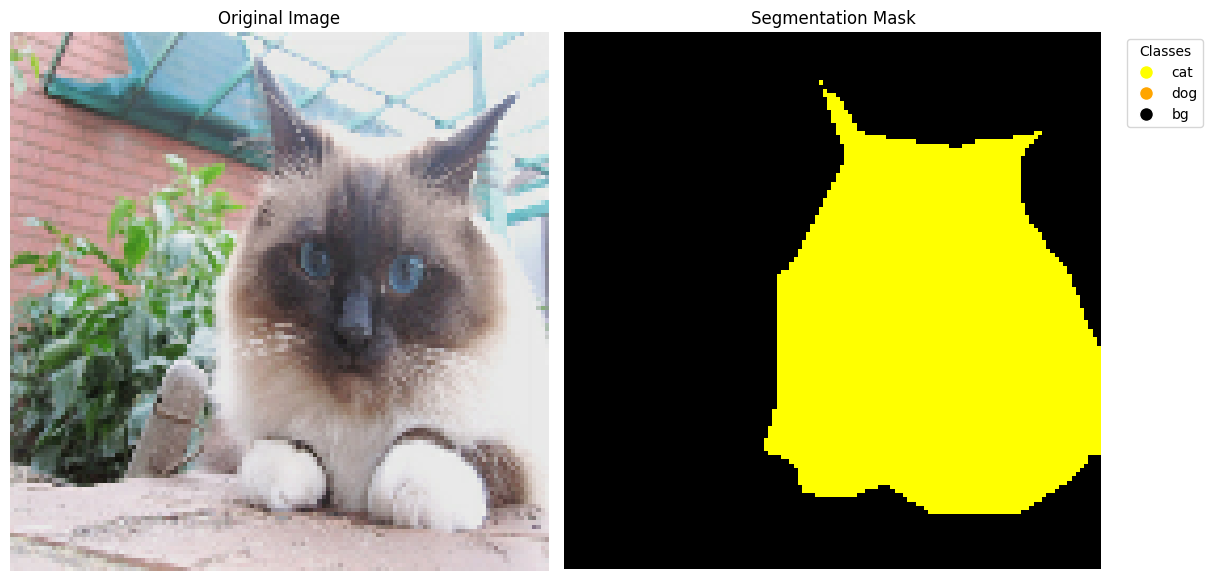

In [10]:
# Merge background with contour
train_features = []
train_labels = []

for instance in train_dataset:
    image = tf.image.resize(instance['image'], (128, 128))
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image.numpy()
    image = image/255
    train_features.append(image)
    mask = tf.image.resize(instance['segmentation_mask'], (128, 128), method='nearest')
    mask = mask.numpy()
    mask = np.where(mask == 3, 2, mask)
    change_labels_species = instance['species']
    change_labels_species = change_labels_species.numpy()
    mask[mask == 1] = change_labels_species
    train_labels.append(mask)


import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

def display(image, mask, bound_box = None):

    color_map = {    0: [255, 255, 0],   # Yellow for cat
    1: [255, 165, 0],   # Orange for dog
    2: [0, 0, 0]  }      # Black for background
    # Convert mask to RGB using the color map
    mask_rgb = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for label, color in color_map.items():
        mask_rgb[mask == label] = color
    mask_rgb = np.squeeze(mask_rgb)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(mask_rgb)
    plt.title("Segmentation Mask")
    plt.axis("off")

    ax = plt.gca()
    if bound_box is not None:
        xmin, ymin, xmax, ymax = bound_box
        color = 'green'
        rect = Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth = 2,
                                                                edgecolor=color, facecolor='none')
        ax.add_patch(rect)

    plt.xlim(0, image.shape[1])
    plt.ylim(image.shape[0], 0)
    labels = ["cat", "dog", "bg"]
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=np.array(color)/255, markersize=10)
        for color in color_map.values()
    ]
    plt.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.2, 1), title="Classes")
    plt.tight_layout()
    plt.show()

display(train_features[10], train_labels[10])

In [11]:
test_features = []
test_labels = []

from sklearn.model_selection import train_test_split

features_train, features_val, labels_train, labels_val = train_test_split(
    train_features, train_labels, test_size=0.2, random_state=42)

for instance in test_dataset:
    image = tf.image.resize(instance['image'], (128, 128))
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image.numpy()
    image = image/255
    test_features.append(image)

    mask = tf.image.resize(instance['segmentation_mask'], (128, 128), method='nearest')
    mask = mask.numpy()

    mask = np.where(mask == 3, 2, mask) # contours must be changed to background

    change_labels_species = instance['species']
    change_labels_species = change_labels_species.numpy()
    mask[mask == 1] = change_labels_species # cat pixel =0  and dog pixels is 1

    test_labels.append(mask)


In [12]:
features_train, labels_train = map(np.array, (features_train, labels_train))
features_val, labels_val = map(np.array, (features_val, labels_val))
test_features, test_labels = map(np.array, (test_features, test_labels))



2. Using a Pre-trained YOLO Model:
- Download a pre-trained YOLO model: YOLOv3 Model
- Convert the model weights .weights to a Keras-compatible .h5/.keras file.
- Load the model and test it on an image by normalizing the image and applying the model for predictions.
- Show the detection results using bounding boxes drawn on the image



In [13]:
def get_bounding_box(segmentation_mask):

    # Find non-zero regions in the segmentation mask (i.e., the pet area)
    pet_pixels = np.argwhere(segmentation_mask > 0)
    # Compute the bounding box coordinates

    ymin, xmin = np.min(pet_pixels, axis=0)
    ymax, xmax = np.max(pet_pixels, axis=0)

    return xmin, ymin, xmax, ymax

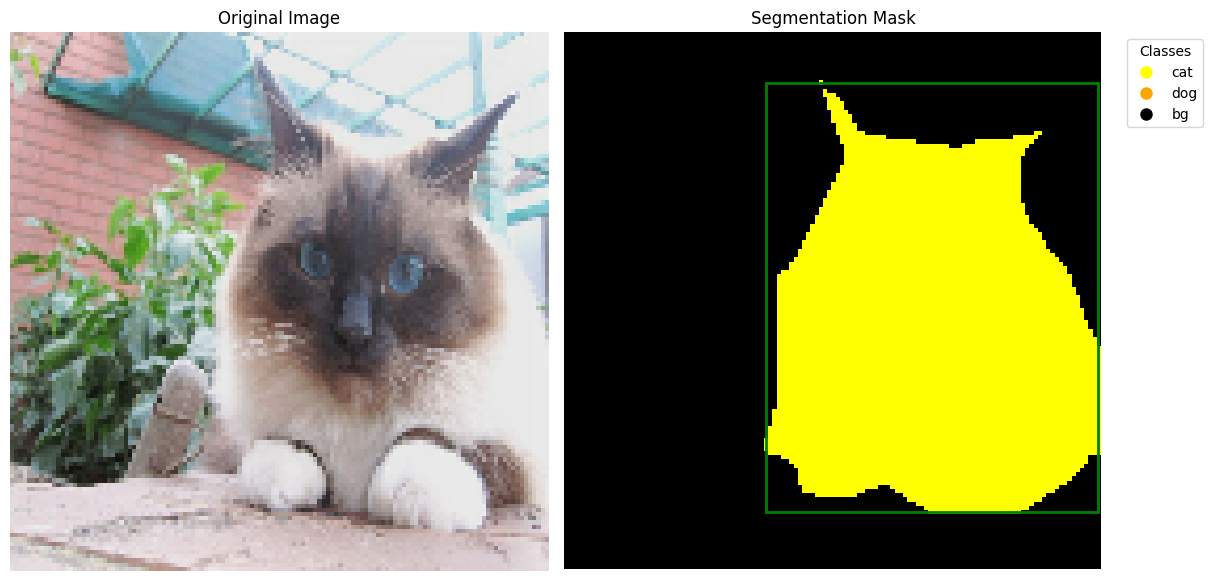

In [14]:
GT_path = "/content/gt_label.txt"
pred_path = "/content/pred_label.txt"
def get_bounding_box(segmentation_mask):
    # Find non-zero regions in the segmentation mask (i.e., the pet area)
    pet_pixels = np.argwhere(segmentation_mask < 2)
    # Compute the bounding box coordinates
    ymin, xmin = np.min(pet_pixels[:, :2], axis=0)
    ymax, xmax = np.max(pet_pixels[:, :2], axis=0)
    return xmin, ymin, xmax, ymax

display(train_features[10], train_labels[10], get_bounding_box(train_labels[10]))

In [15]:
!wget https://raw.githubusercontent.com/experiencor/keras-yolo3/master/yolo3_one_file_to_detect_them_all.py

--2024-11-05 06:34:50--  https://raw.githubusercontent.com/experiencor/keras-yolo3/master/yolo3_one_file_to_detect_them_all.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18653 (18K) [text/plain]
Saving to: ‘yolo3_one_file_to_detect_them_all.py’

yolo3_one_file_to_d 100%[===================>]  18.22K  --.-KB/s    in 0.001s  

2024-11-05 06:34:50 (22.0 MB/s) - ‘yolo3_one_file_to_detect_them_all.py’ saved [18653/18653]



In [17]:
import yolo3_one_file_to_detect_them_all as yl

model = yl.make_yolov3_model()
weight_reader = yl.WeightReader('yolov3.weights')
weight_reader.load_weights(model)
model.save('yolov3.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

loading weights of convolution #63
loading weights of convolution #64
no convolution #65
loading weights of convolution #66
loading weights of convolution #67
no convolution #67
no convolution #68
loading weights of convolution #69
no convolution #69
loading weights of convolution #70
no convolution #70
no convolution #71
loading weights of convolution #72
no convolution #72
loading weights of convolution #73
no convolution #73
no convolution #74
loading weights of convolution #75
no convolution #75
loading weights of convolution #76
no convolution #76
loading weights of convolution #77
no convolution #77
loading weights of convolution #78
no convolution #78
loading weights of convolution #79
no convolution #79
loading weights of convolution #80
no convolution #80
loading weights of convolution #81
no convolution #81
no convolution #82
no convolution #83
loading weights of convolution #84
no convolution #84
no convolution #85
no convolution #86
loading weights of convolution #87
no con

In [18]:
import cv2
from tensorflow.keras.models import load_model
model = load_model("yolov3.h5")
def load_image(image, target_size):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(image, target_size)
    return np.expand_dims(resized_image, axis=0), image
img_path = features_train[8]
input_size = (416, 416)
input_image, original_image = load_image(img_path, input_size)
predictions = model.predict(input_image)
print([prediction.shape for prediction in predictions])

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]


In [19]:
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)

        return self.label

    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]

        return self.score

def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5
    boxes = []
    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh

    for i in range(grid_h*grid_w):
        row = i / grid_w
        col = i % grid_w

        for b in range(nb_box):
            # 4th element is objectness score
            objectness = netout[int(row)][int(col)][b][4]

            if(objectness.all() <= obj_thresh): continue

            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[int(row)][int(col)][b][:4]
            x = (col + x) / grid_w # center position, unit: image width
            y = (row + y) / grid_h # center position, unit: image height
            w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height

            # last elements are class probabilities
            classes = netout[int(row)][col][b][5:]
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            boxes.append(box)

    return boxes

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

In [20]:
# define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
class_threshold = 0.3
boxes = list()
input_h = 416
input_w = 416
for i in range(len(predictions)):
    # decode the output of the network
    boxes += decode_netout(predictions[i][0], anchors[i], class_threshold, input_h, input_w)
# load yolov3 model and perform object detection
# based on https://github.com/experiencor/keras-yolo3
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    new_w, new_h = net_w, net_h

    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

def load_image_pixels(image, shape):
    height, width = image.shape[:2]
    image = cv2.resize(image, shape)
    image = np.expand_dims(image, 0)
    return image, width, height

input_image = features_train[8]
image, image_w, image_h = load_image_pixels(input_image, (input_w, input_h))
correct_yolo_boxes(boxes, image_h, image_w, input_h, image_w)

In [21]:
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
            return 0
        else:
            return min(x2,x4) - x3

def bbox_iou(box_1, box_2):
    intersect_w = _interval_overlap([box_1.xmin, box_1.xmax], [box_2.xmin, box_2.xmax])
    intersect_h = _interval_overlap([box_1.ymin, box_1.ymax], [box_2.ymin, box_2.ymax])
    intersect = intersect_w * intersect_h
    w1, h1 = box_1.xmax-box_1.xmin, box_1.ymax-box_1.ymin
    w2, h2 = box_2.xmax-box_2.xmin, box_2.ymax-box_2.ymin
    union = w1*h1 + w2*h2 - intersect
    return float(intersect) / union

def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            if boxes[index_i].classes[c] == 0: continue
            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]
                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0
do_nms(boxes, 0.5)

In [22]:
def get_boxes(boxes, labels, thresh):
    v_boxes, v_labels, v_scores = list(), list(), list()
    for box in boxes:
        for i in range(len(labels)):
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
    return v_boxes, v_labels, v_scores

# define the labels
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
    "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
    "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
    "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
    "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
    "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
    "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
    "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
    "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
    "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

# get the details of the detected objects
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, 0.4)

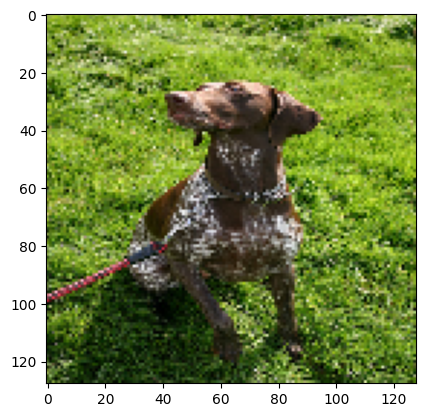

array([('Abyssinian_201',  84, 84, 298, 218, 0, 0.9771271),
       ('Abyssinian_202', 106, 22, 235, 202, 0, 0.9906604),
       ('Abyssinian_204',  54, 37, 205, 297, 0, 0.9727323)],
      dtype=[('image_name', '<U30'), ('x_top_left', '<i4'), ('y_top_left', '<i4'), ('x_bottom_right', '<i4'), ('y_bottom_right', '<i4'), ('label', '<i4'), ('confidence_score', '<f4')])

In [23]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def draw_boxes(image_box, v_boxes, v_labels, v_scores):
    plt.imshow(image_box)
    ax = plt.gca()
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        width, height = x2 - x1, y2 - y1
        rect = Rectangle((x1, y1), width, height, fill=False, color='white')
        ax.add_patch(rect)
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        pyplot.text(x1, y1, label, color='white')
    plt.show()

import matplotlib.pyplot as pyplot
draw_boxes(input_image, v_boxes, v_labels, v_scores)

def load_ground_truth(file_path):
    annotations = []
    with open(file_path, "r") as GT_label_file:
        for line in GT_label_file:
            parts = line.strip().split()
            image_name = parts[0]
            coordinates_and_label = list(map(int, parts[1].split(',')))

            x1, y1, x2, y2, label = coordinates_and_label
            annotations.append((image_name, x1, y1, x2, y2, label))

    dtype = [('image_name', 'U30'), ('x1', 'i4'),('x2', 'i4'),('y1', 'i4'),('y2', 'i4'),('label', 'i4')]

    return np.array(annotations, dtype=dtype)

GT_data = load_ground_truth('gt_label.txt')
GT_data[:3]

def load_Predictions(file_path):
    predictions = []
    with open(file_path, "r") as pred_label_file:
        for line in pred_label_file:
            components = line.strip().split()
            image_name = components[0]
            coordinates_and_confidence = list(map(float, components[1].split(',')))
            predictions.append((image_name, *coordinates_and_confidence))

#             x1, y1, x2, y2, label = coordinates_and_label
#             annotations.append((image_name, x1, y1, x2, y2, label))

    dtype = [('image_name', 'U30'), ('x_top_left', 'i4'),('y_top_left', 'i4'),('x_bottom_right', 'i4'),('y_bottom_right', 'i4'),('label', 'i4'),('confidence_score', 'f4')]

    return np.array(predictions, dtype=dtype)

Pred_data = load_Predictions('pred_label.txt')
Pred_data[:3]

In [24]:
def compute_iou_vectorized(ground_truth_boxes, predicted_boxes):

    ground_truth_boxes = np.array(ground_truth_boxes)
    predicted_boxes = np.array(predicted_boxes)

    inter_x1 = np.maximum(ground_truth_boxes[:, 0], predicted_boxes[:, 0])
    inter_y1 = np.maximum(ground_truth_boxes[:, 1], predicted_boxes[:, 1])
    inter_x2 = np.minimum(ground_truth_boxes[:, 2], predicted_boxes[:, 2])
    inter_y2 = np.minimum(ground_truth_boxes[:, 3], predicted_boxes[:, 3])

    inter_width = np.maximum(0, inter_x2 - inter_x1 + 1)
    inter_height = np.maximum(0, inter_y2 - inter_y1 + 1)
    intersection_area = inter_width * inter_height

    # Calculate the area of the ground truth and predicted boxes
    gt_area = (ground_truth_boxes[:, 2] - ground_truth_boxes[:, 0] + 1) * (ground_truth_boxes[:, 3] - ground_truth_boxes[:, 1] + 1)
    pred_area = (predicted_boxes[:, 2] - predicted_boxes[:, 0] + 1) * (predicted_boxes[:, 3] - predicted_boxes[:, 1] + 1)

    # Calculate union area
    union_area = gt_area + pred_area - intersection_area

    # Calculate IoU
    iou_values = np.where(union_area > 0, intersection_area / union_area, 0)

    return iou_values
def filter_gt_labels(ground_truth_labels, predicted_labels):

    ground_truth_dict = {label[0]: label for label in ground_truth_labels}

    filtered_ground_truth = np.array(
        [ground_truth_dict[prediction[0]] for prediction in predicted_labels if prediction[0] in ground_truth_dict],
        dtype=ground_truth_labels.dtype
    )

    return filtered_ground_truth

filtered_ground_truth_labels = filter_gt_labels(GT_data, Pred_data)

In [25]:
def compute_avg_precision(ground_truth_labels, predicted_labels, target_category, iou_threshold = 0.5):
    true_positive_counts = []
    false_positive_counts = []
    prediction_scores = []

    for ground_truth, prediction in zip(ground_truth_labels, predicted_labels):
        predicted_bbox, predicted_class, confidence_score = [prediction[1],prediction[2], prediction[3], prediction[4]], prediction[5], prediction[6]
        ground_truth_bbox, ground_truth_class = [ground_truth[1], ground_truth[2], ground_truth[3], ground_truth[4]], ground_truth[5]

        iou_value = compute_iou_vectorized([ground_truth_bbox], [predicted_bbox])

        if predicted_class == target_category:
            if iou_value >= iou_threshold and ground_truth_class == target_category:
                true_positive_counts.append(1)
                false_positive_counts.append(0)
            else:
                true_positive_counts.append(0)
                false_positive_counts.append(1)

        else:
            true_positive_counts.append(0)
            false_positive_counts.append(1)

        prediction_scores.append(confidence_score)

    true_positive_counts = np.array(true_positive_counts)
    false_positive_counts = np.array(false_positive_counts)
    prediction_scores = np.array(prediction_scores)

    sorted_indices = np.argsort(prediction_scores)[::-1]
    true_positive_counts = true_positive_counts[sorted_indices]
    false_positive_counts = false_positive_counts[sorted_indices]

    cummulative_tp = np.cumsum(true_positive_counts)
    cummulative_fp = np.cumsum(false_positive_counts)

    precision_values = cummulative_tp / (cummulative_tp + cummulative_fp)
    recall_values = cummulative_tp / np.sum([1 for gt in ground_truth_labels if gt[5] == target_category])

    average_precision = np.sum((recall_values[1:] - recall_values[:-1]) * precision_values[1:])

    return average_precision




In [30]:
iou_thresholds= [0.25, 0.5, 0.75, 0.95]
mean_average_precisions = []

for threshold in iou_thresholds:
    class_aps = []
    for target_category in [0, 1]:
        class_aps.append(compute_avg_precision(filtered_ground_truth_labels, Pred_data, target_category, threshold))
    mean_average_precisions.append(np.mean(class_aps))

for idx, mAP_value in enumerate(mean_average_precisions):
    print(f'MAP at IoU threshold({iou_thresholds[idx]}) is {mAP_value: .4f}')

MAP at IoU threshold(0.25) is  0.4067
MAP at IoU threshold(0.5) is  0.3519
MAP at IoU threshold(0.75) is  0.2792
MAP at IoU threshold(0.95) is  0.0012
